# analysis of placement of created tips
Tim Tyree<br>
7.12.2023

In [1]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *
os.chdir(nb_dir)
from lib import *
# import cupy, cudf
# from lib.rapids_func import *
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [63]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

# dev

In [162]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
folder=f"{nb_dir}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
# folder=f"{nb_dir}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [165]:
DX=0.025
min_num_tips=6
# printing=False
n_lst=[]
Rvec_lst=[]
distance_L2_pbc = get_distance_L2_pbc(width=width, height=height)
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        DT=g['t'].min()
        # if printing:
        # #     print(df_log.describe().loc[['min','max']][['x','y']])
        #     print(f"{width=}, {height=}, {DT=}")

        n_series = g.groupby(by='t')['n'].min()
        t_values_birth = n_series[n_series.diff()==2.].index.values
        for tb in t_values_birth:
            n=n_series.loc[tb]
            if n>=min_num_tips:
                d_prev = g.loc[g['t']==tb-DT]
                d_next = g.loc[g['t']==tb]
                #track the particles in this and the next frame only
                id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                if len(id_pair_lst)>=min_num_tips-2:  #<<< removes cases where it fails to track
                    xy_values = d_next[['x','y']].values
                    #select the new tips
                    i_new_tips = tuple(set(range(n)).difference(np.array(id_pair_lst)[:,1]))
                    i_old_tips = tuple(set(range(n)).difference(i_new_tips))
                    #compute the distance between them
                    dist0=distance_L2_pbc(xy_values[i_new_tips[0]],xy_values[i_new_tips[1]])
                    mindist=10*width
                    minj=-1
                    mini=-1
                    #for each new tip
                    Rvec=np.zeros(min_num_tips-2,dtype='float')
                    for i in i_new_tips:
                        xy=xy_values[i]
                        #compute the distance to nearest preexisting tip
                        dist_lst=[]
                        for j in i_old_tips:
                            dist=distance_L2_pbc(xy,xy_values[j])
                            dist_lst.append(dist)   
                        jarray = np.argsort(dist_lst)[:min_num_tips-2]
                        Rvec+=np.array(dist_lst)[jarray][:min_num_tips-2]*DX #cm
                    Rvec/=len(i_new_tips)
                    #record
                    Rvec_lst.append(Rvec)
                    n_lst.append(n)
    except IndexError as e:
        pass
print (f"{len(n_lst)=}")
beep(3)

len(n_lst)=35637
-n 
-n 
-n 


0

In [164]:
fn

'.DS_Store'

In [166]:
# for tb in t_values_birth:
#     d_prev = g.loc[g['t']==tb-DT]
#     d_next = g.loc[g['t']==tb]
#     id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)        
#DONE: check that local tracking is working
# fig,ax=plt.subplots(figsize=(3,2))
# d_next.plot(kind='scatter',x='x',y='y',marker='.',ax=ax,color='k')

# for ii,(i1,i2) in enumerate(id_pair_lst):
#     ax.scatter(x=d_prev['x'].values[i1],
#                 y=d_prev['y'].values[i1],
#                 c=f'C{ii}',marker='s')
#     ax.scatter(x=d_next['x'].values[i2],
#                 y=d_next['y'].values[i2],
#                 c=f'C{ii}',marker='*',edgecolor='k')
# # format_plot
# ax.axis([0,width,0,height])
# format_plot(xlabel='x (pxl)',ylabel='y (pxl)',fontsize=12,ax=ax)
# ax.tick_params(top=True, right=True,direction='in',which='both')
# plt.show()

In [167]:
X=np.array(Rvec_lst)
#TODO: make a 3d scatter plot of ^that
R1,R2,R3,R4 = zip(*X)
# (R3+R4)/2
R1=np.array(R1)
R2=np.array(R2)
R3=np.array(R3)
R4=np.array(R4)

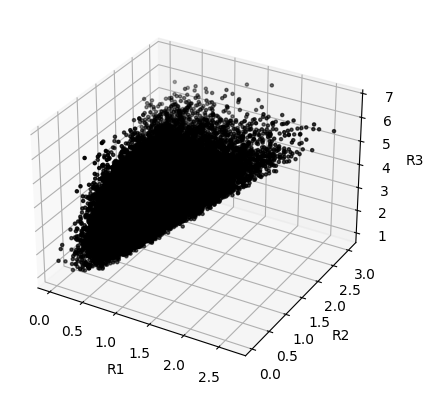

((35637, 4), 35637)

In [168]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R1,R2,R3+R4,marker='.',color='k')
ax.set_xlabel('R1')
ax.set_ylabel('R2')
ax.set_zlabel('R3')
plt.show()
X.shape,len(R1)#,R3.shape

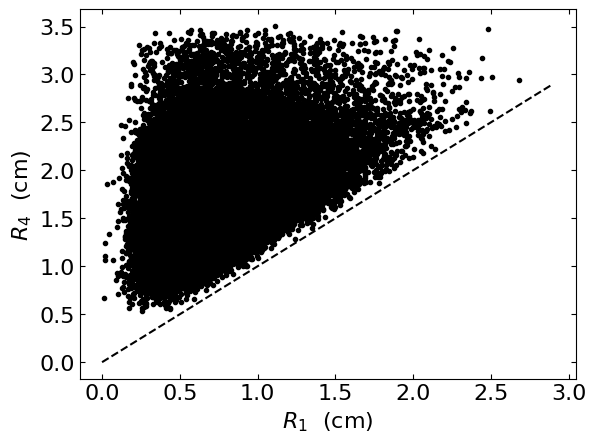

In [169]:
fontsize=16
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
ax.scatter(R1,R4,marker='.',color='k')
# ax.scatter((R1+R2)/2,(R3+R4)/2,marker='.',color='k')
# ax.scatter(np.divide(R1,R4),np.divide(R2,R4),marker='.',color='k')
# ax.scatter(np.divide(2*R1,R3+R4),np.divide(2*R2,R3+R4),marker='.',color='k')
# xv=np.arange(0,1,0.1)
xv=np.arange(0,3,0.1)
ax.plot(xv,xv,'k--')
# format_plot(xlabel=r'$R_1/R_3$',ylabel=r'$R_2/R_3$',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$R_1/R_4$',ylabel=r'$R_2/R_4$',ax=ax,fontsize=fontsize)  #<<<good
# format_plot(xlabel=r'$(R_1+R_2)/2$  (cm)',ylabel=r'$(R_3+R_4)/2$  (cm)',ax=ax,fontsize=fontsize)
format_plot(xlabel=r'$R_1$  (cm)',ylabel=r'$R_4$  (cm)',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$2R_1/(R_3+R_4)$',ylabel=r'$2R_2/(R_3+R_4)$',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()
#heretim

In [170]:
#DONE: make a 2d scatter plot of R1/R3,R2/R3
#TODO: repeat over many trials
#TODO: consider hdbscan to identify a cluster with R1,R2 about the same / much smaller than R3

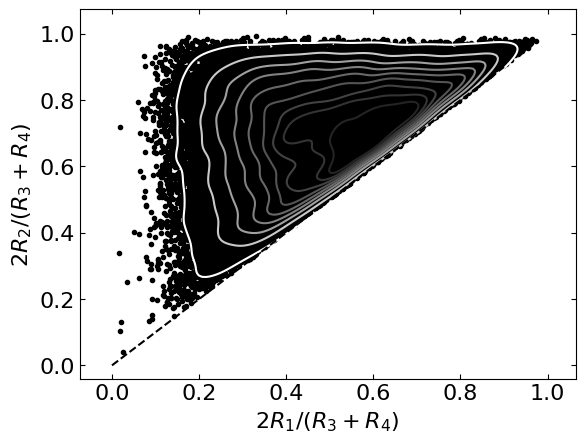

In [177]:
fontsize=16
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')
# ax.scatter(R1,R4,marker='.',color='k')
# x=R1;y=R4
# x=(R1+R2)/2;y=(R3+R4)/2
# x=np.divide(R1,R4);y=np.divide(R2,R4)
x=np.divide(2*R1,R3+R4);y=np.divide(2*R2,R3+R4)
sns.kdeplot(x=x,y=y,cmap=plt.cm.gray_r)#,extent=[xmin, xmax, ymin, ymax])
ax.scatter(x,y,marker='.',color='k')
# ax.scatter(,marker='.',color='k')
# ax.scatter(,marker='.',color='k')
xv=np.arange(0,1,0.1)
# xv=np.arange(0,3,0.1)
ax.plot(xv,xv,'k--')
# format_plot(xlabel=r'$R_1$  (cm)',ylabel=r'$R_4$  (cm)',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$(R_1+R_2)/2$  (cm)',ylabel=r'$(R_3+R_4)/2$  (cm)',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$R_1/R_3$',ylabel=r'$R_2/R_3$',ax=ax,fontsize=fontsize)
# format_plot(xlabel=r'$R_1/R_4$',ylabel=r'$R_2/R_4$',ax=ax,fontsize=fontsize)  #<<<good
format_plot(xlabel=r'$2R_1/(R_3+R_4)$',ylabel=r'$2R_2/(R_3+R_4)$',ax=ax,fontsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.show()
#heretim

In [178]:
beep(3)

-n 
-n 
-n 


0

In [111]:
#DONE: load tip positions from wj
#DONE: identify creation events
#DONE: compute the distance from the mean new tip position to each other tip using periodic b.c.'s
#DONE: order other tips by distance to new tip pair
#DONE: select the first three or four other ranges for creations with at least N0 tips
#DONE: make a 3d scatter plot of ^that
#DONE: make a 2d scatter plot of R1/R3,R2/R3
#TODO: consider hdbscan to identify a cluster with R1,R2 about the same / much smaller than R3